In [16]:
import numpy as np
from pytorch_lightning import seed_everything, LightningModule, Trainer
from sklearn.utils import class_weight
import torch.nn as nn
import torch
from torch.utils.data.dataloader import DataLoader
import torchvision
from sklearn.metrics import classification_report,f1_score,accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
from PIL import Image
import cv2
from torch.utils.data import DataLoader, Dataset,ConcatDataset
from pytorch_lightning.callbacks import EarlyStopping,ModelCheckpoint,LearningRateMonitor
from torch.optim.lr_scheduler import  ReduceLROnPlateau

In [17]:
# 数据增强
# 用 albumentation(instead of torchvision)

import albumentations as A
from albumentations.pytorch import ToTensorV2


img_size=512
aug= A.Compose([
            A.Resize(img_size+32,img_size+32),
            A.RandomCrop(img_size,img_size),
            A.HorizontalFlip(0.5),
            A.VerticalFlip(0.5),
            A.ShiftScaleRotate(rotate_limit=3),
            A.Blur(),A.RandomGamma(),
            A.Sharpen(), A.GaussNoise(),
            A.CoarseDropout(8,64,64),
            A.CLAHE(0.5),
            A.Normalize(mean=(0), std=(1)),
            ToTensorV2(p=1.0),
        ], p=1.0)

In [18]:
# 读取 train和 validation dataset
# read data from folders
class DataReader(Dataset):                        # inherited from Dataset
    def __init__(self, dataset, transform=None):  # constructor
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        x=self.dataset[index][0]   # iamge
        y=self.dataset[index][1]   # label
        if self.transform:         # 先不transform（transform=None），先转换成 np array（albumentation的要求）
            x=np.array(x)
            x=cv2.cvtColor(src=x, code=cv2.COLOR_RGB2GRAY) # to grayscal            
            x=self.transform(image=x)['image']
        return x, y
    
    def __len__(self):
        return len(self.dataset)

In [19]:
# 读取 test dataset
# read data from dataframe                         ## DataFrame 是一个表格型的数据结构
class DFReader(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        x=self.dataset['case'][index]
        if self.transform:
            #x = self.transform(x)
            x=cv2.imread(x,0)
            x=np.array(x)
            #x=cv2.cvtColor(src=x, code=cv2.COLOR_RGB2GRAY)
            x=self.transform(image=x)['image']
        return x
    
    def __len__(self):
        return len(self.dataset)

In [20]:
# 制作list存放test dataset的名字
import os
testset_path = r'multiclass\test'
save_path = r'multiclass'
list = []
for i in os.listdir(testset_path):
    list.append(i)

# 创建一个 pd.DataFrame，并写入一个csv
df = pd.DataFrame({'case': list,
                  'class': None,
                  })
df.to_csv('submission.csv')

# pd.read_csv存放test dataset的路径
test_df=pd.read_csv('./submission.csv',index_col=0) # 去掉行号列
test_df.case='./multiclass/test/'+test_df.case
print(test_df.head())
print('images in test data',len(test_df))

                                         case  class
0         ./multiclass/test/COVID-19 (19).png    NaN
1         ./multiclass/test/COVID-19 (20).png    NaN
2           ./multiclass/test/NORMAL (20).png    NaN
3           ./multiclass/test/NORMAL (19).png    NaN
4  ./multiclass/test/Viral Pneumonia (20).png    NaN
images in test data 6


In [21]:
import timm
import torchmetrics
import torchvision.models as models
from torch.utils.data import random_split
import torchxrayvision as xrv  # 利用一下 weights="resnet50-res512-all"

In [22]:
# use sampler and scheduler
class OurModel(LightningModule):
    def __init__(self,combined,train_subsampler,test_subsampler,test_data=True):
        super(OurModel,self).__init__()
        #architecute
        self.model = xrv.models.ResNet(weights="resnet50-res512-all")
        self.model.model.fc=nn.Sequential(nn.Linear(2048,512),nn.ReLU(),
                              nn.Linear(in_features=512, out_features=3),
                              )
        
        self.model=self.model.model
        self.train_subsampler=train_subsampler
        self.test_subsampler=test_subsampler
        self.combined=combined
        self.test_data=test_data
        #parameters
        self.lr=1e-3
        self.batch_size=1  #### modify here ##
        self.numworker=0              ################################# modify here ########################
        self.acc = torchmetrics.Accuracy(num_classes=3,task='multiclass')# modify here #######
        self.criterion=nn.CrossEntropyLoss() # multiclass
        
        self.trainacc,self.valacc=[],[]
        self.trainloss,self.valloss=[],[]
        self.test_pred=0
        
    def forward(self,x):
        x= self.model(x)
        return x

    def configure_optimizers(self):
        opt=torch.optim.AdamW(params=self.parameters(),lr=self.lr )
        scheduler=ReduceLROnPlateau(opt,mode='min', factor=0.75, patience=5)
        return {'optimizer': opt,'lr_scheduler':scheduler,'monitor':'val_loss'} # return a dictionary#######################
        
 
    def train_dataloader(self):
        return DataLoader(DataReader(self.combined,aug), batch_size = self.batch_size, 
                          num_workers=self.numworker,sampler=self.train_subsampler,pin_memory=True,shuffle=False)

    def training_step(self,batch,batch_idx):       ##### different from binary ###
        image,label=batch
        out = self(image)
        loss=self.criterion(out,label)
        acc=self.acc(out,label)
        return {'loss':loss,'acc':acc}

    def training_epoch_end(self, outputs):
        loss=torch.stack([x["loss"] for x in outputs]).mean().detach().cpu().numpy().round(2)
        acc=torch.stack([x["acc"] for x in outputs]).mean().detach().cpu().numpy().round(2)
        self.trainacc.append(acc)
        self.trainloss.append(loss)
        print('training loss accuracy ',self.current_epoch,loss, acc)
        self.log('train_loss', loss)
        self.log('train_acc', acc)
        
    def val_dataloader(self):
        ds=DataLoader(DataReader(self.combined,aug), batch_size = self.batch_size,
                      num_workers=self.numworker,pin_memory=True,sampler=self.test_subsampler, 
                      shuffle=False  # turn the shuffler off if you are using sampler
                     )
        return ds

    def validation_step(self,batch,batch_idx):   ##### different from binary ###
        image,label=batch
        out=self(image)
        loss=self.criterion(out,label)
        acc=self.acc(out,label)
        return {'loss':loss,'acc':acc}

    def validation_epoch_end(self, outputs):
        loss=torch.stack([x["loss"] for x in outputs]).mean().detach().cpu().numpy().round(2)
        acc=torch.stack([x["acc"] for x in outputs]).mean().detach().cpu().numpy().round(2)
        self.valacc.append(acc)
        self.valloss.append(loss)
        print('validation loss accuracy ',self.current_epoch,loss, acc)
        self.log('val_loss', loss)
        self.log('val_acc', acc)
        
    def test_dataloader(self):
        ds=DataLoader(DFReader(self.test_data,aug), batch_size = self.batch_size,
                      num_workers=self.numworker,pin_memory=True, shuffle=False)
        return ds

    def test_step(self,batch,batch_idx):
        image=batch
        out=self(image)
        return {'pred':out}

    def test_epoch_end(self, outputs):
        pred=torch.cat([x["pred"] for x in outputs])
        print(pred.shape)
        #output is (1200,3)
        #argmax (1200), [1200]
        #pred=torch.argmax(pred,dim=1)
        self.test_pred=pred.detach().cpu().numpy()

In [23]:
train_split = torchvision.datasets.ImageFolder('./multiclass/train/')
val_split = torchvision.datasets.ImageFolder('./multiclass/validation/')
combined = ConcatDataset([train_split,val_split])
print(len(combined))

54


# 交叉验证

## 1.训练集(train)验证集(validation)测试集(test)
https://zhuanlan.zhihu.com/p/35394638

### 训练集

    这个是最好理解的，用来训练模型内参数的数据集

### 验证集

    用于在训练过程中检验模型的状态，收敛情况。验证集通常用于调整超参数，根据几组模型验证集上的表现决定哪组超参数拥有最好的性能。

    同时验证集在训练过程中还可以用来监控模型是否发生过拟合，一般来说验证集表现稳定后，若继续训练，训练集表现还会继续上升，但是验证集会出现不升反降的情况，这样一般就发生了过拟合。所以验证集也用来判断何时停止训练
    
### 测试集
    
    测试集用来评价模型泛化能力，即之前模型使用验证集确定了超参数，使用训练集调整了参数，最后使用一个从没有见过的数据集来判断这个模型是否Work。

## 2. 交叉验证

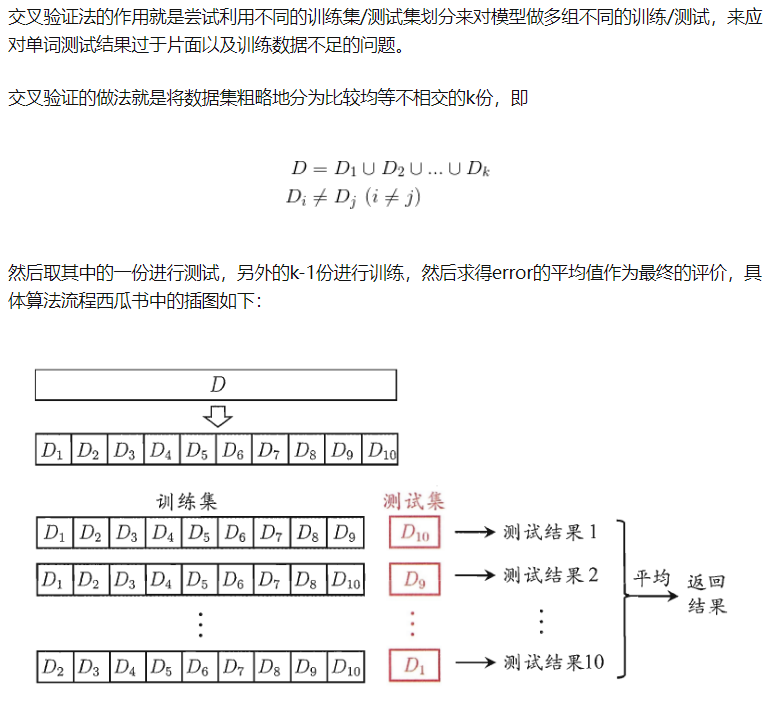

In [24]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5,random_state=21,shuffle=True)  #random_state 随便给个整数？

训练时的学习率调整：optimizer和scheduler

https://zhuanlan.zhihu.com/p/344294796

一般情况下我们会设置随着epoch的增大而逐渐减小学习率从而达到更好的训练效果。

其他参考：https://zhuanlan.zhihu.com/p/389271556

# Pytorch-Lightning中的训练器--Trainer
https://blog.csdn.net/qq_27135095/article/details/122654805

https://pytorch-lightning.readthedocs.io/en/stable/common/trainer.html

In [36]:
fold_pred=[]
for fold,(train_idx,val_idx) in enumerate(kfold.split(combined)):
    print('------------fold no---------{}----------------------'.format(fold))
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)

    checkpoint=ModelCheckpoint(monitor='val_loss',dirpath='checkpoint',filename='file')
    earlystopping=EarlyStopping('val_loss')
    lr_monitor = LearningRateMonitor(logging_interval='epoch')
    
    model=OurModel(combined,train_subsampler,val_subsampler,test_df)
    
    trainer = Trainer(max_epochs=30,
                    # deterministic=True, # seed_everything()
                    gpus=-1,#precision=16,
                    accumulate_grad_batches=4,
                   # progress_bar_refresh_rate=0,
                    callbacks=[lr_monitor,earlystopping,checkpoint],
                    num_sanity_val_steps=0,
                    )
    trainer.fit(model)
    
    torch.save(model.state_dict(), './multiclass/pretrained_models/last_{}.pth'.format(fold)) # 保存模型的参数
    
    #model.load_state_dict(torch.load('./multiclass/pretrained_models/last_{}.pth'.format(fold))) #### modify here ##
    trainer.validate(model)
    trainer.test(model)
    fold_pred.append(model.test_pred)
    #break
    

------------fold no---------0----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | ResNet             | 24.6 M
1 | acc       | MulticlassAccuracy | 0     
2 | criterion | CrossEntropyLoss   | 0     
-------------------------------------------------
24.6 M    Trainable params
0         Non-trainable params
24.6 M    Total params
98.210    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

validation loss accuracy  0 1.11 0.27
training loss accuracy  0 0.28 0.35


Validation: 0it [00:00, ?it/s]

validation loss accuracy  1 1.11 0.27
training loss accuracy  1 0.27 0.28


Validation: 0it [00:00, ?it/s]

validation loss accuracy  2 1.12 0.27
training loss accuracy  2 0.27 0.35


Validation: 0it [00:00, ?it/s]

validation loss accuracy  3 1.12 0.27
training loss accuracy  3 0.27 0.35


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

validation loss accuracy  4 1.13 0.27


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.27000001072883606    │
│         val_loss          │    1.1299999952316284     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

torch.Size([6, 3])
------------fold no---------1----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | ResNet             | 24.6 M
1 | acc       | MulticlassAccuracy | 0     
2 | criterion | CrossEntropyLoss   | 0     
-------------------------------------------------
24.6 M    Trainable params
0         Non-trainable params
24.6 M    Total params
98.210    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

validation loss accuracy  0 1.12 0.27
training loss accuracy  0 0.28 0.35


Validation: 0it [00:00, ?it/s]

validation loss accuracy  1 1.11 0.27
training loss accuracy  1 0.28 0.35


Validation: 0it [00:00, ?it/s]

validation loss accuracy  2 1.11 0.18
training loss accuracy  2 0.27 0.23


Validation: 0it [00:00, ?it/s]

validation loss accuracy  3 1.12 0.09
training loss accuracy  3 0.27 0.35


Validation: 0it [00:00, ?it/s]

validation loss accuracy  4 1.17 0.27
training loss accuracy  4 0.27 0.33


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

validation loss accuracy  5 1.12 0.27


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.27000001072883606    │
│         val_loss          │    1.1200000047683716     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

torch.Size([6, 3])
------------fold no---------2----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | ResNet             | 24.6 M
1 | acc       | MulticlassAccuracy | 0     
2 | criterion | CrossEntropyLoss   | 0     
-------------------------------------------------
24.6 M    Trainable params
0         Non-trainable params
24.6 M    Total params
98.210    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

validation loss accuracy  0 1.11 0.18
training loss accuracy  0 0.28 0.35


Validation: 0it [00:00, ?it/s]

validation loss accuracy  1 1.11 0.18
training loss accuracy  1 0.27 0.26


Validation: 0it [00:00, ?it/s]

validation loss accuracy  2 1.12 0.18
training loss accuracy  2 0.27 0.37


Validation: 0it [00:00, ?it/s]

validation loss accuracy  3 1.16 0.18
training loss accuracy  3 0.27 0.37


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

validation loss accuracy  4 1.15 0.18


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.18000000715255737    │
│         val_loss          │     1.149999976158142     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

torch.Size([6, 3])
------------fold no---------3----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | ResNet             | 24.6 M
1 | acc       | MulticlassAccuracy | 0     
2 | criterion | CrossEntropyLoss   | 0     
-------------------------------------------------
24.6 M    Trainable params
0         Non-trainable params
24.6 M    Total params
98.210    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

validation loss accuracy  0 1.12 0.18
training loss accuracy  0 0.28 0.37


Validation: 0it [00:00, ?it/s]

validation loss accuracy  1 1.12 0.18
training loss accuracy  1 0.27 0.37


Validation: 0it [00:00, ?it/s]

validation loss accuracy  2 1.12 0.18
training loss accuracy  2 0.27 0.37


Validation: 0it [00:00, ?it/s]

validation loss accuracy  3 1.13 0.18
training loss accuracy  3 0.27 0.37


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

validation loss accuracy  4 1.13 0.18


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.18000000715255737    │
│         val_loss          │    1.1299999952316284     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

torch.Size([6, 3])
------------fold no---------4----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | ResNet             | 24.6 M
1 | acc       | MulticlassAccuracy | 0     
2 | criterion | CrossEntropyLoss   | 0     
-------------------------------------------------
24.6 M    Trainable params
0         Non-trainable params
24.6 M    Total params
98.210    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

validation loss accuracy  0 1.11 0.3
training loss accuracy  0 0.28 0.27


Validation: 0it [00:00, ?it/s]

validation loss accuracy  1 1.1 0.3
training loss accuracy  1 0.27 0.32


Validation: 0it [00:00, ?it/s]

validation loss accuracy  2 1.1 0.3
training loss accuracy  2 0.28 0.34


Validation: 0it [00:00, ?it/s]

validation loss accuracy  3 1.08 0.3
training loss accuracy  3 0.27 0.34


Validation: 0it [00:00, ?it/s]

validation loss accuracy  4 1.13 0.3
training loss accuracy  4 0.27 0.2


Validation: 0it [00:00, ?it/s]

validation loss accuracy  5 1.1 0.3
training loss accuracy  5 0.27 0.36


Validation: 0it [00:00, ?it/s]

validation loss accuracy  6 1.18 0.3
training loss accuracy  6 0.27 0.34


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

validation loss accuracy  7 1.17 0.3


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.30000001192092896    │
│         val_loss          │    1.1699999570846558     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

torch.Size([6, 3])


## pytorch中保存的模型文件.pth深入解析
https://zhuanlan.zhihu.com/p/84797438

In [25]:
model.load_state_dict(torch.load('./multiclass/pretrained_models/last_{}.pth'.format(fold))) #### modify here ##

<All keys matched successfully>

In [26]:
trainer.validate(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

validation loss accuracy  4 1.1 0.2


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.20000000298023224    │
│         val_loss          │     1.100000023841858     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 1.100000023841858, 'val_acc': 0.20000000298023224}]

In [27]:
trainer.test(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

torch.Size([6, 3])


[{}]

In [28]:
ls .\multiclass

 Volume in drive H is One Touch
 Volume Serial Number is 6133-8713

 Directory of H:\0. videos\Bilibili\[医学AI-图像分类] 多分类问题-Pytorch源码\multiclass

01/14/2023  07:23 PM    <DIR>          .
01/14/2023  07:23 PM    <DIR>          ..
01/15/2023  08:27 PM    <DIR>          pretrained_models
01/14/2023  07:23 PM    <DIR>          test
01/14/2023  07:23 PM    <DIR>          train
01/14/2023  07:23 PM    <DIR>          validation
               0 File(s)              0 bytes
               6 Dir(s)  1,438,644,830,208 bytes free


In [ ]:
# axis = 0 计算矩阵每一列的平均值/最大值的索引，显示结果为行向量
# axis = 1 计算矩阵每一行的平均值/最大值的索引，显示结果为列向量

In [30]:
import numpy as np
X = np.array([[1,2], [4, 5], [7, 8]])
X = np.mean(X, axis = 0)
print(X)

[4. 5.]


In [31]:
two_dim_array = np.array([[1, 3, 5], [0, 4, 3]])
max_index_axis0 = np.argmax(two_dim_array, axis = 0)
max_index_axis1 = np.argmax(two_dim_array, axis = 1)
print(max_index_axis0)
print(max_index_axis1)

[0 1 0]
[2 1]


In [37]:
pred_mean=np.mean(fold_pred,0)
pred_mean=np.argmax(pred_mean,1)
pred_mean.shape

(6,)

In [38]:
test_df['class']=pred_mean
test_df.to_csv('submission.csv',index=False,header=['case','class'])

In [ ]:
# test leaderboard

```
"Accuracy_score": 0.9358333333333333,
"Sensitivity_score": 0.9358333333333334,
"Specificity_score": 0.9382374634526824
```